In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend, tukey

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/36144/1,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/36144/4,Total threads: 4
Dashboard: http://137.129.155.67:46945/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
path = "/home/durand/Documents/OLR/"

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
indir_data = '/cnrm/tropics/user/peyrille/Stage_PFE_Erwan/data/OLR/'
outdir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'

var_file = 'anom_OLR_brut_ERA5_3H'
var_file = 'olr_anom_wkfilter_'

addDay = 360
spd = 1

In [3]:
rlat = 0
pi    = np.pi
radius = 6.37122e06    # [m]   average radius of earth
radius = 6.37e6
g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
g = 9.8
omega = 7.292e-05      # [1/s] earth's angular vel
ll    = 2.*pi*radius*np.cos(np.abs(rlat))
Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
print(Beta)
Beta = 2.28e-11
fillval = 1e20

2.2894819466248037e-11


In [4]:
def split_hann_taper(series_length, fraction):
    """Implements `split cosine bell` taper of length series_length where only fraction of points are tapered (combined on both ends).
    
    This returns a function that tapers to zero on the ends. To taper to the mean of a series X:
    XTAPER = (X - X.mean())*series_taper + X.mean()
    """
    taper = tukey(series_length,0.05,True)
    return taper, series_length

In [5]:
###################################################################################
def createArray(year) :
    _ds_m1 = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year-1)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds_m1 = _ds_m1.isel(time = slice(addDay*spd,None))
    _ds = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds1 = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year+1)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds1 = _ds1.isel(time = slice(None,addDay*spd))

    ds = xr.concat([_ds_m1,_ds,_ds1], dim='time', coords='minimal', compat='override')
    
    return ds

In [6]:
def kelvinfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, rlat = 0):
    """kelvin wave filterhttp://137.129.155.67:8888/notebooks/TF/ANOMALY/TF_ANOMALY_2D_OLR_ANOMALY_FILTER.ipynb#
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' --equivalent depth
    """
    
    knum = da.freq_lon
    freq = da.freq_time

    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = False)

    #dispersion filter
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c) #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)         #adusting wavenumber to m
        mask = mask.where(lambda da: -(omega - k) <= 0., drop = False)
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c) #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)         #adusting wavenumber to m
        mask = mask.where(lambda da: -(omega - k) >= 0., drop = False)

    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
    filterd = xrft.ifft(_varhat.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True) # Signal in direct space
    filterd['time'] = ds['time']
    return mask, filterd

def mjofilter(da, fmin=None, fmax=None, kmin=None, kmax=None) :
    """kelvin wave filter
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' --equivalent depth
    """
    
    knum = da.freq_lon
    freq = da.freq_time

    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = False)

    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
    filterd = xrft.ifft(_varhat.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True)  # Signal in direct space
    filterd['time'] = ds['time']
    return mask, filterd

def erfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, n=1, rlat = 0):
    """equatorial wave filter
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' -- equivalent depth
       'n'         -- meridional mode number
    """

    if n <=0 or n%1 !=0:
        print ("n must be n>=1 integer")
        sys.exit()

    knum = da.freq_lon
    freq = da.freq_time

    
    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon >= kmin) & (da.freq_lon <= kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time >= fmin) & (da.freq_time <= fmax), drop = False)
        
        
    # filtering ############################################################
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)                          #adusting ^2pia to ^m               
        mask = mask.where(lambda da: -(omega*(k**2 + (2*n+1)) + k) <0., drop = False)   
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)   
        mask = mask.where(lambda da: -(omega*(k**2 + (2*n+1)) + k) > 0., drop = False)             

    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
    filterd = xrft.ifft(_varhat.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True) # Signal in direct space
    filterd['time'] = ds['time']
    return mask, filterd

def mrgfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None,):
    """mixed Rossby gravity wave
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number. negative is westward, positive is
                      eastward
       'hmin/hmax' -- equivalent depth
    """
    
    knum = da.freq_lon
    freq = da.freq_time
    
        
    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = False)
        
        
    #dispersion filter
    mask = mask.where((da.freq_lon <= -1.), drop = False)
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                         #adusting ^2pia to ^m               
        mask = mask.where(lambda da: -(omega**2 - k*omega - 1) <= 0., drop = False) 
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)                 #adusting ^2pia to ^m               
        mask = mask.where(lambda da: -(omega**2 - k*omega - 1) >= 0., drop = False) 
  
    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
    filterd = xrft.ifft(_varhat.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True) # Signal in direct space
    filterd['time'] = ds['time']
    return mask, filterd

def igfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, n=1):
    """n>=1 inertio gravirt wave filter. default is n=1 WIG.
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number. negative is westward, positive is
                      eastward
       'hmin/hmax' -- equivalent depth
       'n'         -- meridional mode number
    """

    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = False)
        
    knum = da.freq_lon
    freq = da.freq_time
    #dispersion filter
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                   #adusting ^2pia to ^m               
        mask = mask.where(lambda da: -(omega**2 - k**2 - (2*n+1)) <= 0., drop = False) 
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = -2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                      #adusting ^2pia to ^m               
        mask = mask.where(lambda da: -(omega**2 - k**2 - (2*n+1)) >= 0., drop = False) 
        
        
    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
    filterd = xrft.ifft(_varhat.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True) # Signal in direct space
    filterd['time'] = ds['time']
    return mask, filterd

In [7]:
def deletebug(da, ds):
    
    _da = da.real.values + xu.conj(da).real.values
#     _da = np.roll( _da, 180, axis = 2)

    da = xr.DataArray(_da,
                       dims=("time","lat","lon"), 
                       coords={"time":ds.time,
                               "lat":ds.lat,
                               "lon":ds.lon})
    da = da.sel(time = str(f))
    da['time'] = date_Re
      
    return da

In [14]:
filenames = np.arange(2008,2009)
var = 'OLR'
units = "W/m^2"

for f in filenames:
    date_Re = pd.date_range(start = (str(f) + '-01-01'), end = (str(f + 1) + '-01-01'), freq = '24H', closed = 'left')
    ds = createArray(f)
#     x_wintap = ds['OLR_ano'].chunk({"time" : -1, "lat": 1})
    x_wintap = ds['olr_anom'].chunk({"time" : -1, "lat": 1}).load()
#     taper,tt = split_hann_taper(x_wintap.time.size, 0.05) 
#     print(x_wintap)
#     for i in range(x_wintap.lat.size):
#         for j in range(x_wintap.lon.size):
            
#             x_wintap[:,i,j] = x_wintap[:,i,j] # * taper
            
    x_wintap = x_wintap.assign_coords(lon=(x_wintap.lon - 180))
#     x_wintap = x_wintap.rolling(time=8, center=True).mean()
    

    tcwvhat = xrft.fft(x_wintap, dim=['time','lon'], 
                       true_phase=False, true_amplitude=True)

    _tcwvhat = tcwvhat.copy()

#     
    #####################################
    ### We save freq_lon in ° and freq_time in second, because we use wavenumber and cycle by day for filtering
    freq_lon_Save = tcwvhat['freq_lon']
    freq_time_Save = tcwvhat['freq_time']
    #####################################
    wavenumber = np.zeros(_tcwvhat.freq_lon.size)
    for i in range( _tcwvhat.freq_lon.size):
        j= - int(360/2) + i
        wavenumber[i] = _tcwvhat.freq_lon[int(360/2)+j]*360 + 1
    #     print(wavenumber[i])

    _tcwvhat['freq_lon'] = wavenumber
    _tcwvhat['freq_time'] = tcwvhat.freq_time*86400
    #####################################
    # Kelvin Filtering
    # kelvin: (Straub Kiladis, Kiladis 2009)
    tMin = 2.5
    tMax = 30.
    kMin = 1
    kMax = 14
    hMin = 8
    hMax = 90


    _dahat_Kev, da_Kevfilter = kelvinfilter(_tcwvhat, fmin = -1/tMin, fmax = -1/tMax, kmax = kMax, kmin = 1, hmin=8, hmax=90)
    da_Kevfilter = deletebug(da_Kevfilter, ds)
    
    da_Kevfilter.attrs['units'] = units
    da_Kevfilter.attrs['tMin'] = str(tMin)
    da_Kevfilter.attrs['tMax'] = str(tMax)
    da_Kevfilter.attrs['kMin'] = str(kMin)
    da_Kevfilter.attrs['kMax'] = str(kMax)
    da_Kevfilter.attrs['hMin'] = str(hMin)
    da_Kevfilter.attrs['hMax'] = str(hMax)

    ######################################
    # Rossby Filtering
    # n=1 Eq. Rossby  Kiladis et al 2009
    tMin = 9.7
    tMax = 48.
    kMin = -10
    kMax = -1
    hMin = 8 
    hMax = 90

    _dahat_Ross, da_Rossfilter = erfilter(_tcwvhat, fmin = -1/tMin, fmax = -1/tMax, kmax = kMax, kmin = kMin, hmin=8, hmax=90)
    da_Rossfilter = deletebug(da_Rossfilter, ds)
    
    da_Rossfilter.attrs['units'] = units
    da_Rossfilter.attrs['tMin'] = str(tMin)
    da_Rossfilter.attrs['tMax'] = str(tMax)
    da_Rossfilter.attrs['kMin'] = str(kMin)
    da_Rossfilter.attrs['kMax'] = str(kMax)
    da_Rossfilter.attrs['hMin'] = str(hMin)
    da_Rossfilter.attrs['hMax'] = str(hMax)
    
    #########################################
    # MJO Filtering
    # MJO
    # waveName = "MJO"   ; kiladis et al. 2009
    tMin = 30.
    tMax = 96.
    kMin = 1
    kMax = 5  # 5 is also possible

    _dahat_MJO, da_MJOfilter = mjofilter(_tcwvhat, fmin = -1/tMin, fmax= -1/tMax, kmax = kMax, kmin = kMin)
    da_MJOfilter = deletebug(da_MJOfilter, ds)

    da_MJOfilter.attrs['tMin'] = str(tMin)
    da_MJOfilter.attrs['tMax'] = str(tMax)
    da_MJOfilter.attrs['kMin'] = str(kMin)
    da_MJOfilter.attrs['kMax'] = str(kMax)

    #############################################
    # MRG Filtering
    # MRG
    tMin = 3.
    tMax = 8.
    kMin = -10
    kMax = -1
    hMin = 8
    hMax = 90

    _dahat_MRG, da_MRGfilter = mrgfilter(_tcwvhat, fmin = -1/3, fmax = -1/8, kmax = -1, kmin = -10, hmin = 8, hmax = 90)
    da_MRGfilter = deletebug(da_MRGfilter, ds)

    da_MRGfilter.attrs['tMin'] = str(tMin)
    da_MRGfilter.attrs['tMax'] = str(tMax)
    da_MRGfilter.attrs['kMin'] = str(kMin)
    da_MRGfilter.attrs['kMax'] = str(kMax)
    da_MRGfilter.attrs['hMin'] = str(hMin)
    da_MRGfilter.attrs['hMax'] = str(hMax)

    ################################################
    # IGW Filtering
    # EIG  (Wheeler Kiladis 1998)    
    tMin = 1.
    tMax = 5.
    kMin = 14
    kMax = 1
    hMin = 12  
    hMax = 50
   
    _dahat_EIG, da_EIGfilter = igfilter(_tcwvhat, fmin = -1, fmax = -1/5, kmin=1, kmax=14, hmin=12)
    da_EIGfilter = deletebug(da_EIGfilter, ds)

    da_EIGfilter.attrs['tMin'] = str(tMin)
    da_EIGfilter.attrs['tMax'] = str(tMax)
    da_EIGfilter.attrs['kMin'] = str(kMin)
    da_EIGfilter.attrs['kMax'] = str(kMax)
    da_EIGfilter.attrs['hMin'] = str(hMin)
    da_EIGfilter.attrs['hMax'] = str(hMax)

    # WIG  (Wheeler Kiladis 1998)
    tMin = 1.
    tMax = 5.
    kMin = 14
    kMax = 1
    hMin = 12 
    hMax = 50
    
    _dahat_WIG, da_WIGfilter = igfilter(_tcwvhat, fmin = -1/1.25, fmax = -1/2, kmin=-14, kmax=-1, hmin=12, hmax=50)
    da_WIGfilter = deletebug(da_WIGfilter, ds)

    da_WIGfilter.attrs['tMin'] = str(tMin)
    da_WIGfilter.attrs['tMax'] = str(tMax)
    da_WIGfilter.attrs['kMin'] = str(kMin)
    da_WIGfilter.attrs['kMax'] = str(kMax)
    da_WIGfilter.attrs['hMin'] = str(hMin)
    da_WIGfilter.attrs['hMax'] = str(hMax)
    ######################################################
    # TD filtering
    
    # TD (Easterly wave) : 
    tMin = 2.5
    tMax = 7.
    kMin = -20
    kMax = -6
    # hMin = mis  ==> Min curve = up curve of MRG Domain
    # hMax = mis
    _dahat_TD, da_TDfilter = mrgfilter(_tcwvhat, fmin = -1/2.5, fmax = -1/7, kmax = -6, kmin = -20, hmin = 12)
    da_TDfilter = deletebug(da_TDfilter, ds)

    da_TDfilter.attrs['tMin'] = str(tMin)
    da_TDfilter.attrs['tMax'] = str(tMax)
    da_TDfilter.attrs['kMin'] = str(kMin)
    da_TDfilter.attrs['kMax'] = str(kMax)
    
    ########################################################
    # Low Frequency Filtering
    # Low frequency 
    tMin = 120.
    tMax = 999
    kMin = -10
    kMax = 10
    
    _dahat_LF, da_LFfilter = mjofilter(_tcwvhat, fmin = -1/120, fmax= -1/999, kmax = 10, kmin = -10)
    da_LFfilter = deletebug(da_LFfilter, ds)

    da_LFfilter.attrs['tMin'] = str(tMin)
    da_LFfilter.attrs['tMax'] = str(tMax)
    da_LFfilter.attrs['kMin'] = str(kMin)
    da_LFfilter.attrs['kMax'] = str(kMax)
    
    
    # #######################################################
    # #######################################################
    # delete bug 
    
    #######################################################
    #######################################################
    # NetCDF save
    ds_NetCdf = da_Kevfilter.to_dataset(name = var + '_Kelvin')
    ds_NetCdf[var + '_Rossby'] = da_Rossfilter
    ds_NetCdf[var + '_MJO'] = da_MJOfilter
    ds_NetCdf[var + '_MRG'] = da_MRGfilter
    ds_NetCdf[var + '_EIG'] = da_EIGfilter
    ds_NetCdf[var + '_WIG'] = da_WIGfilter
    ds_NetCdf[var + '_TD'] = da_TDfilter
    ds_NetCdf[var + '_LF'] = da_LFfilter 

    ds_NetCdf.time.encoding['units'] = "hours since 1900-01-01"
    ds_NetCdf.time.encoding['calendar'] = "proleptic_gregorian"
    ds_NetCdf.time.encoding['standard_name'] = "time"
    ds_NetCdf = ds_NetCdf.sel(time = str(f))
    ds_NetCdf.to_netcdf(outdir_data + 'OLR_ERWAN_3H_' + str(f) +'_V2.nc', unlimited_dims='time')

<xarray.DataArray 'olr_anom' (time: 731, lat: 33, lon: 144)>
array([[[ 15.546585  ,  15.082016  ,  15.462616  , ...,  -7.3595734 ,
          17.53865   ,  19.116653  ],
        [ 25.539154  ,  19.591934  ,  -1.0408783 , ...,  18.221298  ,
          31.56134   ,  27.291382  ],
        [ 25.557098  ,   9.594971  , -61.991653  , ...,  25.705048  ,
          25.925934  ,  27.211304  ],
        ...,
        [-79.78735   , -79.7218    , -64.52341   , ..., -19.511124  ,
         -70.656296  , -51.046432  ],
        [-25.626556  , -37.614944  , -71.39752   , ...,  23.700058  ,
          21.913422  ,  14.546097  ],
        [  2.0943146 , -38.166687  , -44.363052  , ...,  10.327896  ,
          24.894043  ,  14.223373  ]],

       [[ 13.558563  ,  25.889862  ,  32.284058  , ..., -14.602798  ,
          -8.745407  ,  -0.66833496],
        [ 25.960297  ,  31.3629    ,  33.891357  , ...,  10.926651  ,
          22.497421  ,  23.50978   ],
        [ 28.3918    ,  28.9225    ,  29.103958  , ...,  22.

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xrft/xrft.py:556: 

In [13]:
ds_NetCdf

<xarray.Dataset>
Dimensions:     (time: 366, lat: 33, lon: 144)
Coordinates:
  * time        (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * lat         (lat) float32 -40.0 -37.5 -35.0 -32.5 ... 32.5 35.0 37.5 40.0
  * lon         (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
Data variables:
    OLR_Kelvin  (time, lat, lon) float64 -5.517 -10.44 -14.05 ... -10.88 -3.944
    OLR_Rossby  (time, lat, lon) float64 3.488 1.419 -0.3999 ... 3.58 3.716
    OLR_MJO     (time, lat, lon) float64 -0.2609 -0.6549 ... -0.7954 -0.7374
    OLR_MRG     (time, lat, lon) float64 -5.487 -4.254 -2.866 ... -3.023 -3.585
    OLR_EIG     (time, lat, lon) float64 2.077 2.045 1.733 ... -8.797 -7.832
    OLR_WIG     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    OLR_TD      (time, lat, lon) float64 0.8414 1.281 0.2658 ... 1.856 0.5651
    OLR_LF      (time, lat, lon) float64 6.398 6.632 6.668 ... 4.007 3.184 2.026

IndexError: index 2684 is out of bounds for axis 0 with size 366

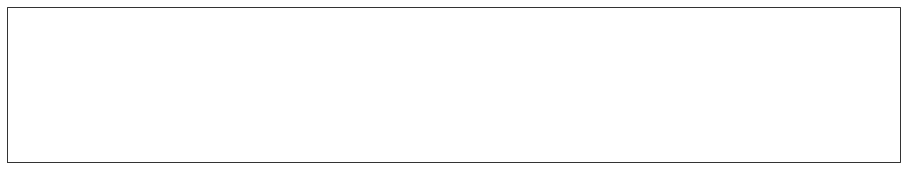

In [10]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_WIGfilter.real.isel(time = int(5368/2)).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

power = da_MJOfilter
for i in range(20) :
    fig, axis = plt.subplots(
        1, 1, subplot_kw={'projection': map_proj})

    power.isel(time = i*8*4).plot.contourf(ax=axis, levels = 101,
                        transform=ccrs.PlateCarree())

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_Kevfilter.real.sel(time ='01-01-2008T00').plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_Rossfilter.real.isel(time = int(5368/2)).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_MRGfilter.real.isel(time = int(5368/2)).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_EIGfilter.real.isel(time = int(5368/2)).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

da_TDfilter.real.isel(time = int(5368/2)).plot.contourf(ax=axis, levels = 101,
                    transform=ccrs.PlateCarree())

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

test = (_dahat_WIG.real*xu.conj(_dahat_WIG)).real.sum('lat')

In [ ]:
test.plot.contourf(x='freq_lon', y = 'freq_time', levels = 20,
                       cmap='Spectral_r', vmax = 10)